# Anomaly detection

In this tutorial we'll be using Temporian to perform exploratory data analysis and feature engineering on the ServerMachineDataset (SMD), published as part of the [OmniAnomaly](https://github.com/NetManAIOps/OmniAnomaly/) paper, to then train a simple MLP (multi-layer perceptron, or fully-connected neural network) model on it in a supervised fashion to detect anomalies.

The ServerMachineDataset (hosted as csv files in that same repository) is a 5-week-long dataset collected from a large internet company. It is made up of system metrics (such as CPU utilization, network in and out, memory usage, etc.) from 28 different machines belonging to 3 groups.

The data has been anonymized and normalized, so there's no telling what feature means what, and it's also had its timestamps removed, so we will need to treat it as a normal time series, since we know the values are sequential, but don't know how much time has passed between each one. This makes us lose out on some of Temporian's potential - but perfectly illustrates that Temporian can be used on time series data too!

## Installation and imports

We'll be using scikit-learn's MLPClassifier as our model, since our dataset isn't too large (about 700k rows) and a simple two-layer neural network trained on CPU seems to be fit for the job.

In [1]:
%pip install temporian -q


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight

import temporian as tp

## Downloading the dataset

The dataset is comprised of 3 groups of 8, 9, and 11 machines respectively, with names `"machine-1-1"`, ..., `"machine-3-11"`.

Let's create the list of names, and then download each machine's data and labels to a `tmp/temporian_server_machine_dataset/` folder.

In [3]:
# Create list of machine names
machines_per_group = [8, 9, 11]
machines = [f"machine-{group}-{id}" for group, machine in zip(range(1, 4), machines_per_group) for id in range(1, machine + 1)]

machines

['machine-1-1',
 'machine-1-2',
 'machine-1-3',
 'machine-1-4',
 'machine-1-5',
 'machine-1-6',
 'machine-1-7',
 'machine-1-8',
 'machine-2-1',
 'machine-2-2',
 'machine-2-3',
 'machine-2-4',
 'machine-2-5',
 'machine-2-6',
 'machine-2-7',
 'machine-2-8',
 'machine-2-9',
 'machine-3-1',
 'machine-3-2',
 'machine-3-3',
 'machine-3-4',
 'machine-3-5',
 'machine-3-6',
 'machine-3-7',
 'machine-3-8',
 'machine-3-9',
 'machine-3-10',
 'machine-3-11']

In [4]:
data_dir = Path("tmp/temporian_server_machine_dataset")

data_dir.mkdir(parents=True, exist_ok=True)

DATA = "data.csv"
LABELS = "labels.csv"

# Download the data and labels for each machine to its own folder
for machine in machines:
    print(f"Downloading data and labels for {machine}")
    
    dir = data_dir / machine
    dir.mkdir(exist_ok=True)
    
    data_path = dir / DATA
    if not data_path.exists():
        os.system(f"wget -q -O {data_path} https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test/{machine}.txt")

    labels_path = dir / LABELS
    if not labels_path.exists():
        os.system(f"wget -q -O {labels_path} https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test_label/{machine}.txt")

## Loading the data

We'll use pandas to load the data and perform some basic manipulation of it before transforming it into a Temporian `EventSet`.

Note that in the code below, we'll be using the loaded data's pandas index (which is a sequential one) as the `"timestamp"` column for each DataFrame. This will effectively render a time series, since each new event will be one unit of time ahead of the previous one, but it means that the timestamp column has no actual semantic meaning, and should not be used for feature engineering at all.

In [5]:
dfs = []

for machine in machines:
    dir = data_dir / machine

    # Read the data and labels
    df = pd.read_csv(dir / DATA, header=None)
    labels = pd.read_csv(dir/ LABELS, header=None)
    df = df.assign(label=labels)

    # Assign the group and machine as features (note that the group is the 8th character in "machine-1-1")
    df["group"] = machine[8]
    df["machine"] = machine
    
    # Use index as timestamps column
    df = df.reset_index(drop=False, names="timestamp")

    # Cast column names to string
    df.columns = df.columns.astype(str)

    print(f"Events in {machine}: {len(df)}")
    dfs.append(df)

df = pd.concat(dfs)
df

Events in machine-1-1: 28479
Events in machine-1-2: 23694
Events in machine-1-3: 23703
Events in machine-1-4: 23707
Events in machine-1-5: 23706
Events in machine-1-6: 23689
Events in machine-1-7: 23697
Events in machine-1-8: 23699
Events in machine-2-1: 23694
Events in machine-2-2: 23700
Events in machine-2-3: 23689
Events in machine-2-4: 23689
Events in machine-2-5: 23689
Events in machine-2-6: 28743
Events in machine-2-7: 23696
Events in machine-2-8: 23703
Events in machine-2-9: 28722
Events in machine-3-1: 28700
Events in machine-3-2: 23703
Events in machine-3-3: 23703
Events in machine-3-4: 23687
Events in machine-3-5: 23691
Events in machine-3-6: 28726
Events in machine-3-7: 28705
Events in machine-3-8: 28704
Events in machine-3-9: 28713
Events in machine-3-10: 23693
Events in machine-3-11: 28696


,timestamp,0,1,2,3,4,5,6,7,8,...,31,32,33,34,35,36,37,label,group,machine
0,0,0.075269,0.065678,0.070234,0.074332,0.000000,0.933333,0.274011,0.0,0.031081,...,0.048893,0.000386,0.000034,0.064432,0.064500,0.000000,0.0,0,1,machine-1-1
1,1,0.086022,0.080508,0.075808,0.076655,0.000000,0.930769,0.274953,0.0,0.031081,...,0.050437,0.000386,0.000022,0.065228,0.065224,0.000000,0.0,0,1,machine-1-1
2,2,0.075269,0.064619,0.071349,0.074332,0.000000,0.928205,0.274953,0.0,0.030940,...,0.055069,0.000386,0.000045,0.067111,0.067178,0.000000,0.0,0,1,machine-1-1
3,3,0.086022,0.048729,0.063545,0.070848,0.000000,0.928205,0.273070,0.0,0.027250,...,0.051467,0.000000,0.000034,0.066676,0.066744,0.000000,0.0,0,1,machine-1-1
4,4,0.086022,0.051907,0.062430,0.070848,0.000000,0.933333,0.274011,0.0,0.030940,...,0.051467,0.000386,0.000022,0.066604,0.066671,0.000000,0.0,0,1,machine-1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28691,28691,0.180000,0.137442,0.147727,0.214186,0.038282,0.239338,0.775022,0.0,0.000000,...,0.000000,0.105263,0.318182,0.402446,0.402012,0.128557,0.0,0,3,machine-3-11
28692,28692,0.180000,0.115180,0.141084,0.210000,0.038282,0.239380,0.775163,0.0,0.000000,...,0.000000,0.052632,0.227273,0.400819,0.400531,0.129237,0.0,0,3,machine-3-11
28693,28693,0.180000,0.119697,0.140909,0.208605,0.038282,0.239394,0.775210,0.0,0.000000,...,0.000000,0.052632,0.181818,0.394523,0.394875,0.148011,0.0,0,3,machine-3-11
28694,28694,0.180000,0.081303,0.126049,0.200465,0.038282,0.239380,0.775069,0.0,0.000000,...,0.000000,0.052632,0.045455,0.390662,0.390122,0.122109,0.0,0,3,machine-3-11


In [6]:
df.describe()

,timestamp,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,label
count,708420.000000,708420.000000,708420.000000,708420.000000,708420.000000,708420.000000,708420.000000,708420.000000,708420.0,708420.000000,...,708420.000000,708420.000000,708420.000000,708420.000000,708420.000000,708420.000000,708420.000000,708420.000000,708420.000000,708420.000000
mean,12757.271575,0.160686,0.086226,0.098888,0.113795,0.238911,0.712696,0.393758,0.0,0.024270,...,0.121081,0.208342,0.113507,0.039236,0.054533,0.223638,0.220811,0.018056,0.010181,0.041563
std,7495.191084,0.161099,0.125249,0.141293,0.163208,0.399149,0.286226,0.299432,0.0,0.058701,...,0.183360,0.191475,0.152171,0.086949,0.109251,0.218597,0.220283,0.076995,0.063242,0.199588
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6325.000000,0.040404,0.003553,0.004760,0.005961,0.000000,0.492630,0.124229,0.0,0.000178,...,0.001005,0.051437,0.000362,0.000000,0.004537,0.041667,0.040404,0.000000,0.000000,0.000000
50%,12650.000000,0.103093,0.029312,0.036170,0.041291,0.000000,0.803033,0.329559,0.0,0.004336,...,0.027397,0.153205,0.061760,0.000000,0.016854,0.154545,0.146646,0.000000,0.000000,0.000000
75%,18975.000000,0.247423,0.121539,0.134453,0.148537,0.433962,0.985549,0.570502,0.0,0.021812,...,0.200000,0.325357,0.158607,0.023256,0.046443,0.350322,0.348993,0.000000,0.000000,0.000000
max,28742.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Awesome! Seems like we have 708420 rows and 42 columns in our dataset, made up of:
- 38 metric columns, which will be the main features we'll be working on with Temporian
- 2 categorical columns, which will allow us to tell apart events that belong to different machines
- 1 timestamps column
- 1 labels column

As stated previously, all metrics seem to be anonymized and normalized to [0, 1], so we won't need to take care of that ourselves.

## Creating an EventSet

Now that our data's ready, let's create a Temporian `EventSet` from it.

We'll use the `"group"` and `"machine"` columns as its index, which means that Temporian will treat the events corresponding to each machine as an independent time series when computing features off of it. This is clear when displaying the `EventSet`, which renders one table for each of our indexes' values.

Note that, since we used one column as timestamps and two others as indexes, our `EventSet` has 39 features instead of the previous 42.

In [7]:
tp.config.max_display_features = 100
tp.config.max_display_events = 5

evset = tp.from_pandas(df, indexes=["group", "machine"])

print(evset.schema.features)

evset

[('0', float64), ('1', float64), ('2', float64), ('3', float64), ('4', float64), ('5', float64), ('6', float64), ('7', float64), ('8', float64), ('9', float64), ('10', float64), ('11', float64), ('12', float64), ('13', float64), ('14', float64), ('15', float64), ('16', float64), ('17', float64), ('18', float64), ('19', float64), ('20', float64), ('21', float64), ('22', float64), ('23', float64), ('24', float64), ('25', float64), ('26', float64), ('27', float64), ('28', float64), ('29', float64), ('30', float64), ('31', float64), ('32', float64), ('33', float64), ('34', float64), ('35', float64), ('36', float64), ('37', float64), ('label', int64)]


timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,label
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07415,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,0
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01473,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.09459,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,0,0,0.1274,0.09449,0.09817,0.07752,0.9422,0.0184,0.03411,0.01696,0,0.08093,0,0.008596,0.07093,0.05147,0.000386,2.2e-05,0.0666,0.06667,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,label
0,0.23,0.1095,0.1266,0.1338,0.2264,0.621,0.4093,0,9.3e-05,1.5e-05,0,0.00722,0,0.03696,0.003551,0.02929,0,0,0.002313,0.0108,0.005868,0.04877,0.07143,0.08159,0.2,0.07692,0,0.01994,0,0,0.04801,0,0,0.0625,0,0,0,0,0
1,0.25,0.1089,0.1271,0.134,0.2264,0.5473,0.337,0,9.3e-05,1.5e-05,0,0.009025,0,0.03926,0.004129,0.03305,0,0,0.01261,0.02618,0.01733,0.0752,0.1071,0.159,0.2,0.1538,0,0.03768,0,0,0.07518,0,0,0.05556,0,0.5,0,0,0
2,0.24,0.1228,0.1308,0.1353,0.2264,0.4784,0.2648,0,0.000653,0.000134,8e-06,0.01805,0,0.09858,0.009166,0.09242,0,0,0.1534,0.02637,0.1565,0.2137,0,0.159,0.2,0.1581,0,0.1788,0,0,0.2129,0,0,0.06944,0,0,0,0,0


Let's free up some memory by deleting the pandas DataFrame and casting all of our features to float32 (which will also make Temporian create new float32 features when applying operators on the original ones) and our label to int32.

In [8]:
del df

In [9]:
evset = evset.cast(tp.float32).cast({"label": tp.int32})
evset.schema.features

[('0', float32),
 ('1', float32),
 ('2', float32),
 ('3', float32),
 ('4', float32),
 ('5', float32),
 ('6', float32),
 ('7', float32),
 ('8', float32),
 ('9', float32),
 ('10', float32),
 ('11', float32),
 ('12', float32),
 ('13', float32),
 ('14', float32),
 ('15', float32),
 ('16', float32),
 ('17', float32),
 ('18', float32),
 ('19', float32),
 ('20', float32),
 ('21', float32),
 ('22', float32),
 ('23', float32),
 ('24', float32),
 ('25', float32),
 ('26', float32),
 ('27', float32),
 ('28', float32),
 ('29', float32),
 ('30', float32),
 ('31', float32),
 ('32', float32),
 ('33', float32),
 ('34', float32),
 ('35', float32),
 ('36', float32),
 ('37', float32),
 ('label', int32)]

## Data visualization

Let's take a look at our first index value's data. For this, we'll limit the number of plots shown by Temporian to 39, which will show us the 39 plots corresponding to the first index value.

The number of plots (1092) is larger than "options.max_num_plots=39". Only the first plots will be printed.


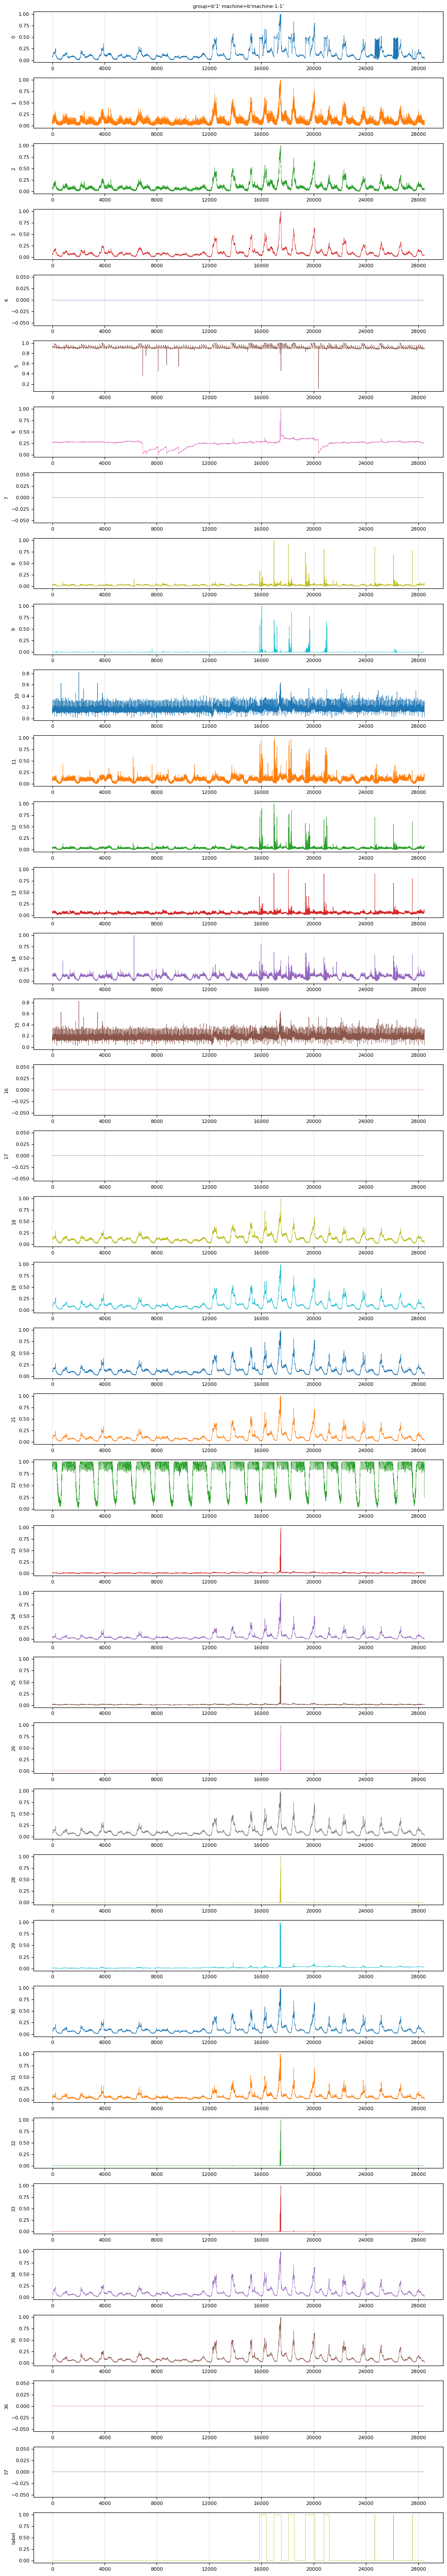

In [10]:
evset.plot(max_num_plots=39)

Great! A lot to unpack here:
- It seems to be easy to understand when an anomaly occurs (label takes value of 1) by looking at the other plots. Features 11 to 14, for example, seem to be very correlated to the label.
- The data seems to have some periodicity to it.
- Some features seem empty, and we could evaluate dropping them if needed.

## Data preparation

To prepare our data to train a model on it, let's start off by separating the features from the labels.

In [11]:
feature_names = evset.schema.feature_names()
feature_names.remove('label')

raw_features = evset[feature_names]
labels = evset[['label']]

print("Raw features:", raw_features.schema)
print("Labels:", labels.schema)

Raw features: features: [('0', float32), ('1', float32), ('2', float32), ('3', float32), ('4', float32), ('5', float32), ('6', float32), ('7', float32), ('8', float32), ('9', float32), ('10', float32), ('11', float32), ('12', float32), ('13', float32), ('14', float32), ('15', float32), ('16', float32), ('17', float32), ('18', float32), ('19', float32), ('20', float32), ('21', float32), ('22', float32), ('23', float32), ('24', float32), ('25', float32), ('26', float32), ('27', float32), ('28', float32), ('29', float32), ('30', float32), ('31', float32), ('32', float32), ('33', float32), ('34', float32), ('35', float32), ('36', float32), ('37', float32)]
indexes: [('group', str_), ('machine', str_)]
is_unix_timestamp: False

Labels: features: [('label', int32)]
indexes: [('group', str_), ('machine', str_)]
is_unix_timestamp: False



Next, we'll need to split our dataset into train and testing sets, which we'll use an 80/20 split for.

We'll be creating reusable functions for each step, since we'll do some iteration over the `feature engineering -> training -> evaluation cycle`.

In [12]:
CATEGORICAL_COLS = ["group", "machine"]
DROP_COLS = CATEGORICAL_COLS + ["timestamp"]

def make_datasets(X: tp.EventSet, y: tp.EventSet):
    """Splits X and y into train and test sets and transforms categorical features into one-hot-encoded features."""

    # Compute the timestamp that corresponds to 80% of the data, and use it to split the data
    last_train_timestamp = int(len(X.get_arbitrary_index_data()) * 0.8)
    timestamp = X.timestamps()
    X_train = X.filter(timestamp <= last_train_timestamp)
    X_test = X.filter(timestamp > last_train_timestamp)
    y_train = y.filter(timestamp <= last_train_timestamp)
    y_test = y.filter(timestamp > last_train_timestamp)

    # Using a DataFrame for these last few steps to feed into the scikit-learn model
    # Note that even though the raw data has no NaNs, we will create some during our feature engineering
    X_train = tp.to_pandas(X_train).fillna(-1)
    
    # Define and fit the one-hot encoder for our categorical features
    encoder = OneHotEncoder(sparse_output=False)
    train_encoded = encoder.fit_transform(X_train[CATEGORICAL_COLS])

    # Replace timestamp and categorical columns with the new encoded ones
    X_train = X_train.drop(columns=DROP_COLS)
    X_train = np.concatenate([X_train.to_numpy(), train_encoded], axis=1)

    # Repeat process for test set
    X_test = tp.to_pandas(X_test).fillna(-1)
    test_encoded = encoder.transform(X_test[CATEGORICAL_COLS])
    X_test = X_test.drop(columns=DROP_COLS)
    X_test = np.concatenate([X_test.to_numpy(), test_encoded], axis=1)

    # Cast our labels and remove timestamp and categorical columns
    y_train = tp.to_pandas(y_train).drop(columns=DROP_COLS).squeeze()
    y_test = tp.to_pandas(y_test).drop(columns=DROP_COLS).squeeze()

    print("Number of samples in train set", len(X_train))
    print("Number of positive (anomalous) samples in train set", y_train.sum())
    print("Number of samples in test set", len(X_test))
    print("Number of positive (anomalous) samples in test set", y_test.sum())

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = make_datasets(raw_features, labels)

Number of samples in train set 530740
Number of positive (anomalous) samples in train set 19924
Number of samples in test set 177680
Number of positive (anomalous) samples in test set 9520


Those numbers look alright. However, we seem to be dealing with a fairly unbalanced dataset, with the positive labels in the training set accounting for only 3% of the total. We'll remember to take that into account when evaluating our model.

## Training

Having done all that work to prepare our data, all that remains is to train our MLP. A small network will do the trick.

In [13]:
def train(X_train, y_train):
    model = MLPClassifier(
        hidden_layer_sizes=(64, 16),
        learning_rate='adaptive',
        learning_rate_init=0.0001,
        batch_size=512,
        tol=0.001,
        n_iter_no_change=3,
        random_state=0,
        verbose=True,
    )
    model.fit(X_train, y_train)
    return model

model = train(X_train, y_train)

Iteration 1, loss = 0.34503776
Iteration 2, loss = 0.15501901
Iteration 3, loss = 0.13529508
Iteration 4, loss = 0.12660414
Iteration 5, loss = 0.11987173
Iteration 6, loss = 0.11333901
Iteration 7, loss = 0.10689516
Iteration 8, loss = 0.10148850
Iteration 9, loss = 0.09715973
Iteration 10, loss = 0.09374331
Iteration 11, loss = 0.09094424
Iteration 12, loss = 0.08859868
Iteration 13, loss = 0.08663604
Iteration 14, loss = 0.08487289
Iteration 15, loss = 0.08333174
Iteration 16, loss = 0.08187184
Iteration 17, loss = 0.08058236
Iteration 18, loss = 0.07940777
Iteration 19, loss = 0.07830005
Iteration 20, loss = 0.07730430
Iteration 21, loss = 0.07642572
Iteration 22, loss = 0.07558967
Iteration 23, loss = 0.07483352
Training loss did not improve more than tol=0.001000 for 3 consecutive epochs. Stopping.


## Evaluation

As we noticed previously, the dataset is very unbalanced. The MLPClassifier returns the mean accuracy over each possible class (0 or 1 in our case) in `.score()`, which would make it very hard to assess how well we're doing on the cases we value the most. Luckily, that same function accepts a `sample_weight` parameter, which we'll use to balance out the impact of each class' accuracy on the final score.

In [14]:
# Compute class weights (we only need to do this once, since it won't be changing while we iterate over feature engineering)
classes = y_train.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

print("Class weights:", class_weights)

Class weights: {0: 0.5195021299254526, 1: 13.319112627986348}


Train score: 0.7294265466493653
Test score: 0.7430686577949336
Train predictions
Test predictions


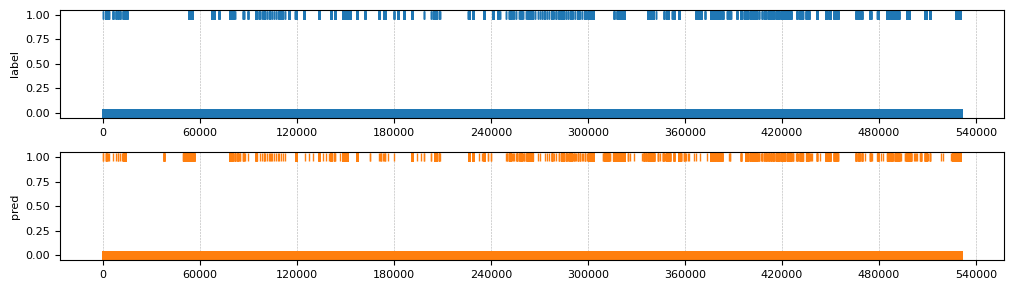

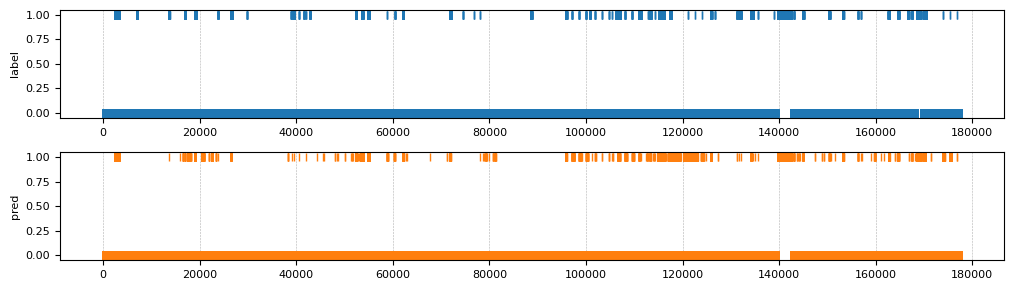

In [15]:
figsize=(20,3)

def eval(model, X_train, y_train, X_test, y_test):
    """Evaluates a model on its training data and unseen test data, computing accuracy score and plotting ground truth vs predictions."""
    # Compute sample weights based on class weights
    train_sample_weights = compute_sample_weight(class_weights, y_train)
    test_sample_weights = compute_sample_weight(class_weights, y_test)
    
    # Compute scores
    print("Train score:", model.score(X_train, y_train, sample_weight=train_sample_weights))
    print("Test score:", model.score(X_test, y_test, sample_weight=test_sample_weights))

    # Get predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    print("Train predictions")
    tp.event_set(timestamps=y_train.index, features={"label": y_train, "pred": train_preds}).plot(style="vline")

    print("Test predictions")
    tp.event_set(timestamps=y_test.index, features={"label": y_test, "pred": test_preds}).plot(style="vline")

eval(model, X_train, y_train, X_test, y_test)

That's pretty decent for a first try. Our model seems to be learning, but not overfitting, on its training data. There's plenty of room for improvement though, so let's kick off the feature engineering!

## Feature engineering

### Lag features

Right now our model only has access to each event's raw metric values, + the group and machine that it belongs to. This means that it has no knowledge of the **context** an event is happening on - some values might have been completely normal when the measuring started, but anomalous a couple of weeks later, e.g. if that machine's usage went up as a whole during that time and its baseline usage now stands much higher than it used to.

To combat this, we'll start by lagging the values of each feature. In doing this, we're providing the model (some) information about that the metric's value looked like a couple of steps into the past.

In [16]:
lag_features = []

# Lag each raw feature by 1, 2, ..., 10 steps
for window in range(1, 11):
    lag_features.append(raw_features.lag(window).resample(raw_features).prefix(f"lag_{window}_"))

features = tp.glue(raw_features, *lag_features)
features

timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,lag_1_0,lag_1_1,lag_1_2,lag_1_3,lag_1_4,lag_1_5,lag_1_6,lag_1_7,lag_1_8,lag_1_9,lag_1_10,lag_1_11,lag_1_12,lag_1_13,lag_1_14,lag_1_15,lag_1_16,lag_1_17,lag_1_18,lag_1_19,lag_1_20,lag_1_21,lag_1_22,lag_1_23,lag_1_24,lag_1_25,lag_1_26,lag_1_27,lag_1_28,lag_1_29,lag_1_30,lag_1_31,lag_1_32,lag_1_33,lag_1_34,lag_1_35,lag_1_36,lag_1_37,lag_2_0,lag_2_1,lag_2_2,lag_2_3,lag_2_4,lag_2_5,lag_2_6,lag_2_7,lag_2_8,lag_2_9,lag_2_10,lag_2_11,lag_2_12,lag_2_13,lag_2_14,lag_2_15,lag_2_16,lag_2_17,lag_2_18,lag_2_19,lag_2_20,lag_2_21,lag_2_22,lag_2_23,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,…
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,…
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,0,0,0.1274,0.09449,0.09817,0.07752,0.9422,0.0184,0.03411,0.01696,0,0.08093,0,0.008596,0.07093,0.05147,0.000386,2.2e-05,0.0666,0.06667,0,0,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,3

Let's take a look at any metric alongside its lagged values. We'll select a small time window, to be able to appreciate how the time series moves to the right as the number of lagged timesteps increases.

The number of plots (308) is larger than "options.max_num_plots=20". Only the first plots will be printed.


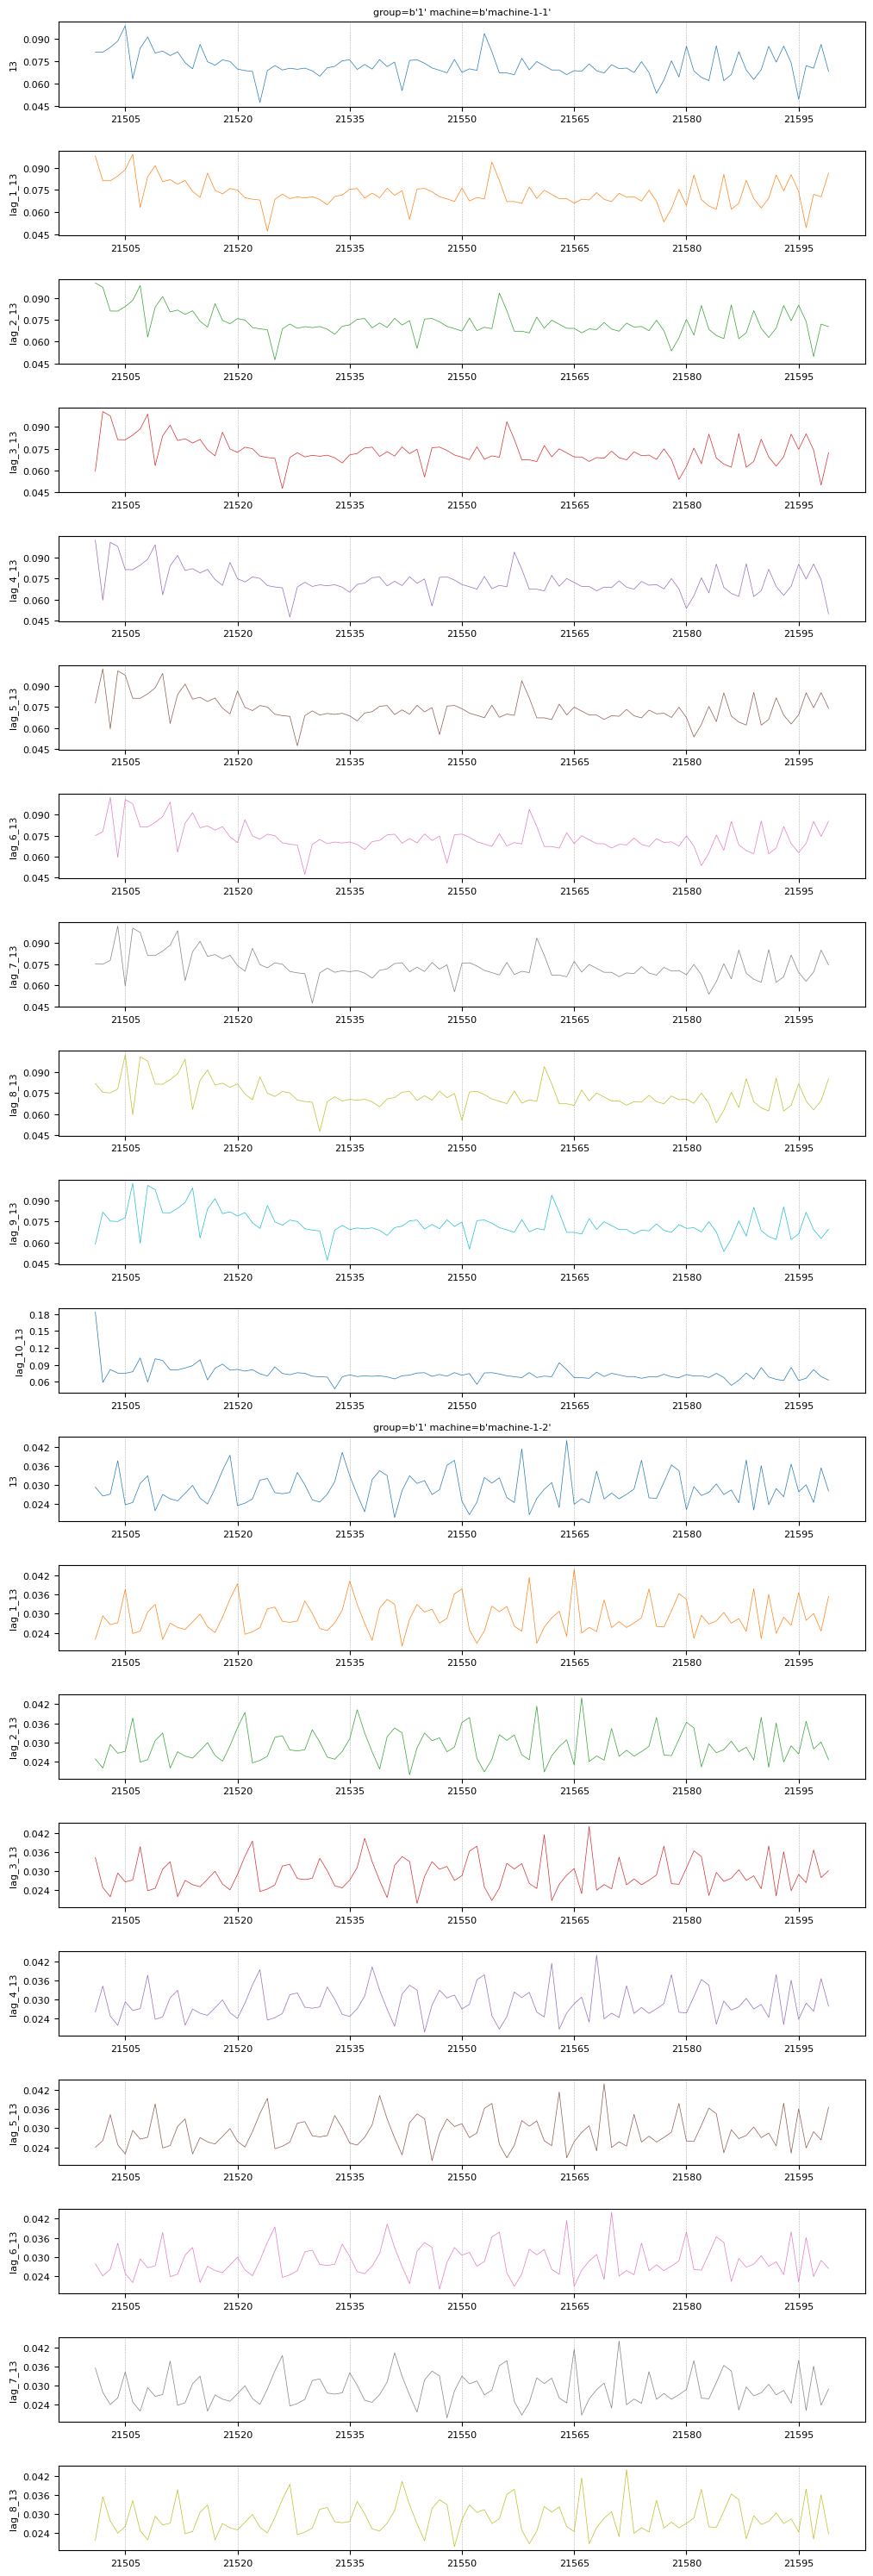

In [17]:
f13_lags = features[["13"] + [f"lag_{i}_13" for i in range(1, 11)]]
timestamps = f13_lags.timestamps()
f13_lags = f13_lags.filter((timestamps > 21500) & (timestamps < 21600))
f13_lags.plot()

Time to train and evaluate a new model with these new features! 

Number of samples in train set 530740
Number of positive (anomalous) samples in train set 19924
Number of samples in test set 177680
Number of positive (anomalous) samples in test set 9520
Iteration 1, loss = 0.17171084
Iteration 2, loss = 0.12023287
Iteration 3, loss = 0.10126718
Iteration 4, loss = 0.09010414
Iteration 5, loss = 0.08287343
Iteration 6, loss = 0.07784763
Iteration 7, loss = 0.07406445
Iteration 8, loss = 0.07114809
Iteration 9, loss = 0.06881916
Iteration 10, loss = 0.06689912
Iteration 11, loss = 0.06528602
Iteration 12, loss = 0.06368283
Iteration 13, loss = 0.06235183
Iteration 14, loss = 0.06103413
Iteration 15, loss = 0.05996377
Iteration 16, loss = 0.05891913
Iteration 17, loss = 0.05791169
Iteration 18, loss = 0.05712730
Iteration 19, loss = 0.05616036
Iteration 20, loss = 0.05527883
Iteration 21, loss = 0.05464666
Training loss did not improve more than tol=0.001000 for 3 consecutive epochs. Stopping.
Train score: 0.7886170723509717
Test score: 0.7788067437445

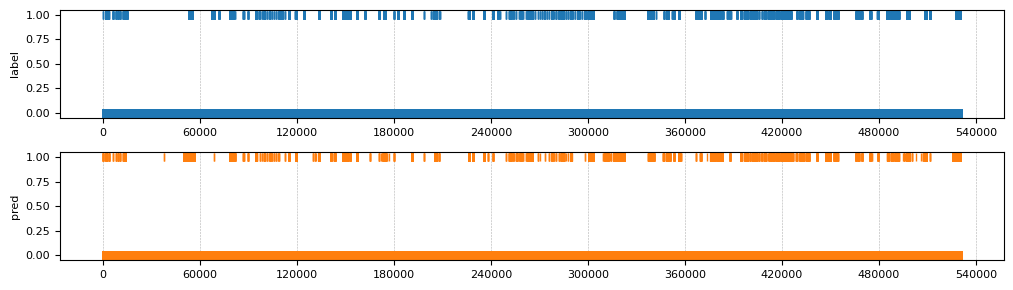

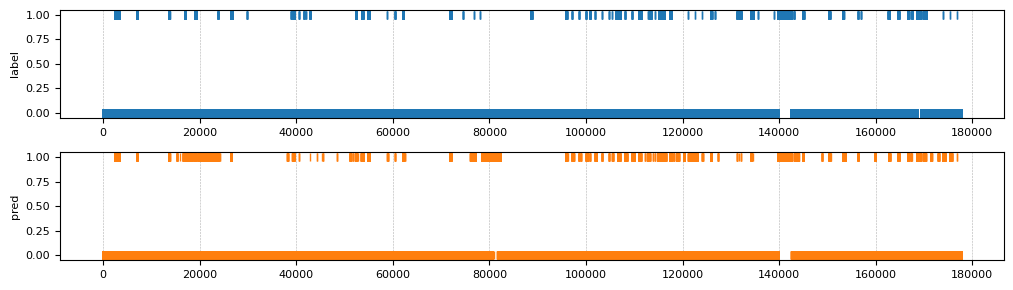

In [18]:
X_train, y_train, X_test, y_test = make_datasets(features, labels)
model = train(X_train, y_train)
eval(model, X_train, y_train, X_test, y_test)

### Moving statistic features

The improvement in performance given by the lag features was significant!

However, although useful, the raw lagged values aren't enough to provide the model a comprehensive look at each value's past context. Note also that we only gave it a glimpse of 10 steps into the past, and each time series has more than 24k values.

This is where **moving statistics** can come in handy. Instead of a list of raw values, we can provide the model an aggregation of each metric's values over the last N timesteps. For example, we can tell it what the maximum and minimum value of a metric were in the last steps, of what the standard deviation was in the last 1000. 

Luckily, Temporian's window operators make this a breeze.

In [19]:
moving_statistic_features = []

# Compute the moving average, standard deviation, max, and min over different windows
for window in [20, 200, 2000]:
    moving_statistic_features.append(raw_features.simple_moving_average(window).prefix(f"avg_{window}_"))
    moving_statistic_features.append(raw_features.moving_standard_deviation(window).prefix(f"std_{window}_"))
    moving_statistic_features.append(raw_features.moving_max(window).prefix(f"max_{window}_"))
    moving_statistic_features.append(raw_features.moving_min(window).prefix(f"min_{window}_"))

features = tp.glue(raw_features, *lag_features, *moving_statistic_features)
features

timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,lag_1_0,lag_1_1,lag_1_2,lag_1_3,lag_1_4,lag_1_5,lag_1_6,lag_1_7,lag_1_8,lag_1_9,lag_1_10,lag_1_11,lag_1_12,lag_1_13,lag_1_14,lag_1_15,lag_1_16,lag_1_17,lag_1_18,lag_1_19,lag_1_20,lag_1_21,lag_1_22,lag_1_23,lag_1_24,lag_1_25,lag_1_26,lag_1_27,lag_1_28,lag_1_29,lag_1_30,lag_1_31,lag_1_32,lag_1_33,lag_1_34,lag_1_35,lag_1_36,lag_1_37,lag_2_0,lag_2_1,lag_2_2,lag_2_3,lag_2_4,lag_2_5,lag_2_6,lag_2_7,lag_2_8,lag_2_9,lag_2_10,lag_2_11,lag_2_12,lag_2_13,lag_2_14,lag_2_15,lag_2_16,lag_2_17,lag_2_18,lag_2_19,lag_2_20,lag_2_21,lag_2_22,lag_2_23,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,…
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,…
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,0,0,0.1274,0.09449,0.09817,0.07752,0.9422,0.0184,0.03411,0.01696,0,0.08093,0,0.008596,0.07093,0.05147,0.000386,2.2e-05,0.0666,0.06667,0,0,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,3

Taking a look at some of the generated features:

The number of plots (140) is larger than "options.max_num_plots=20". Only the first plots will be printed.


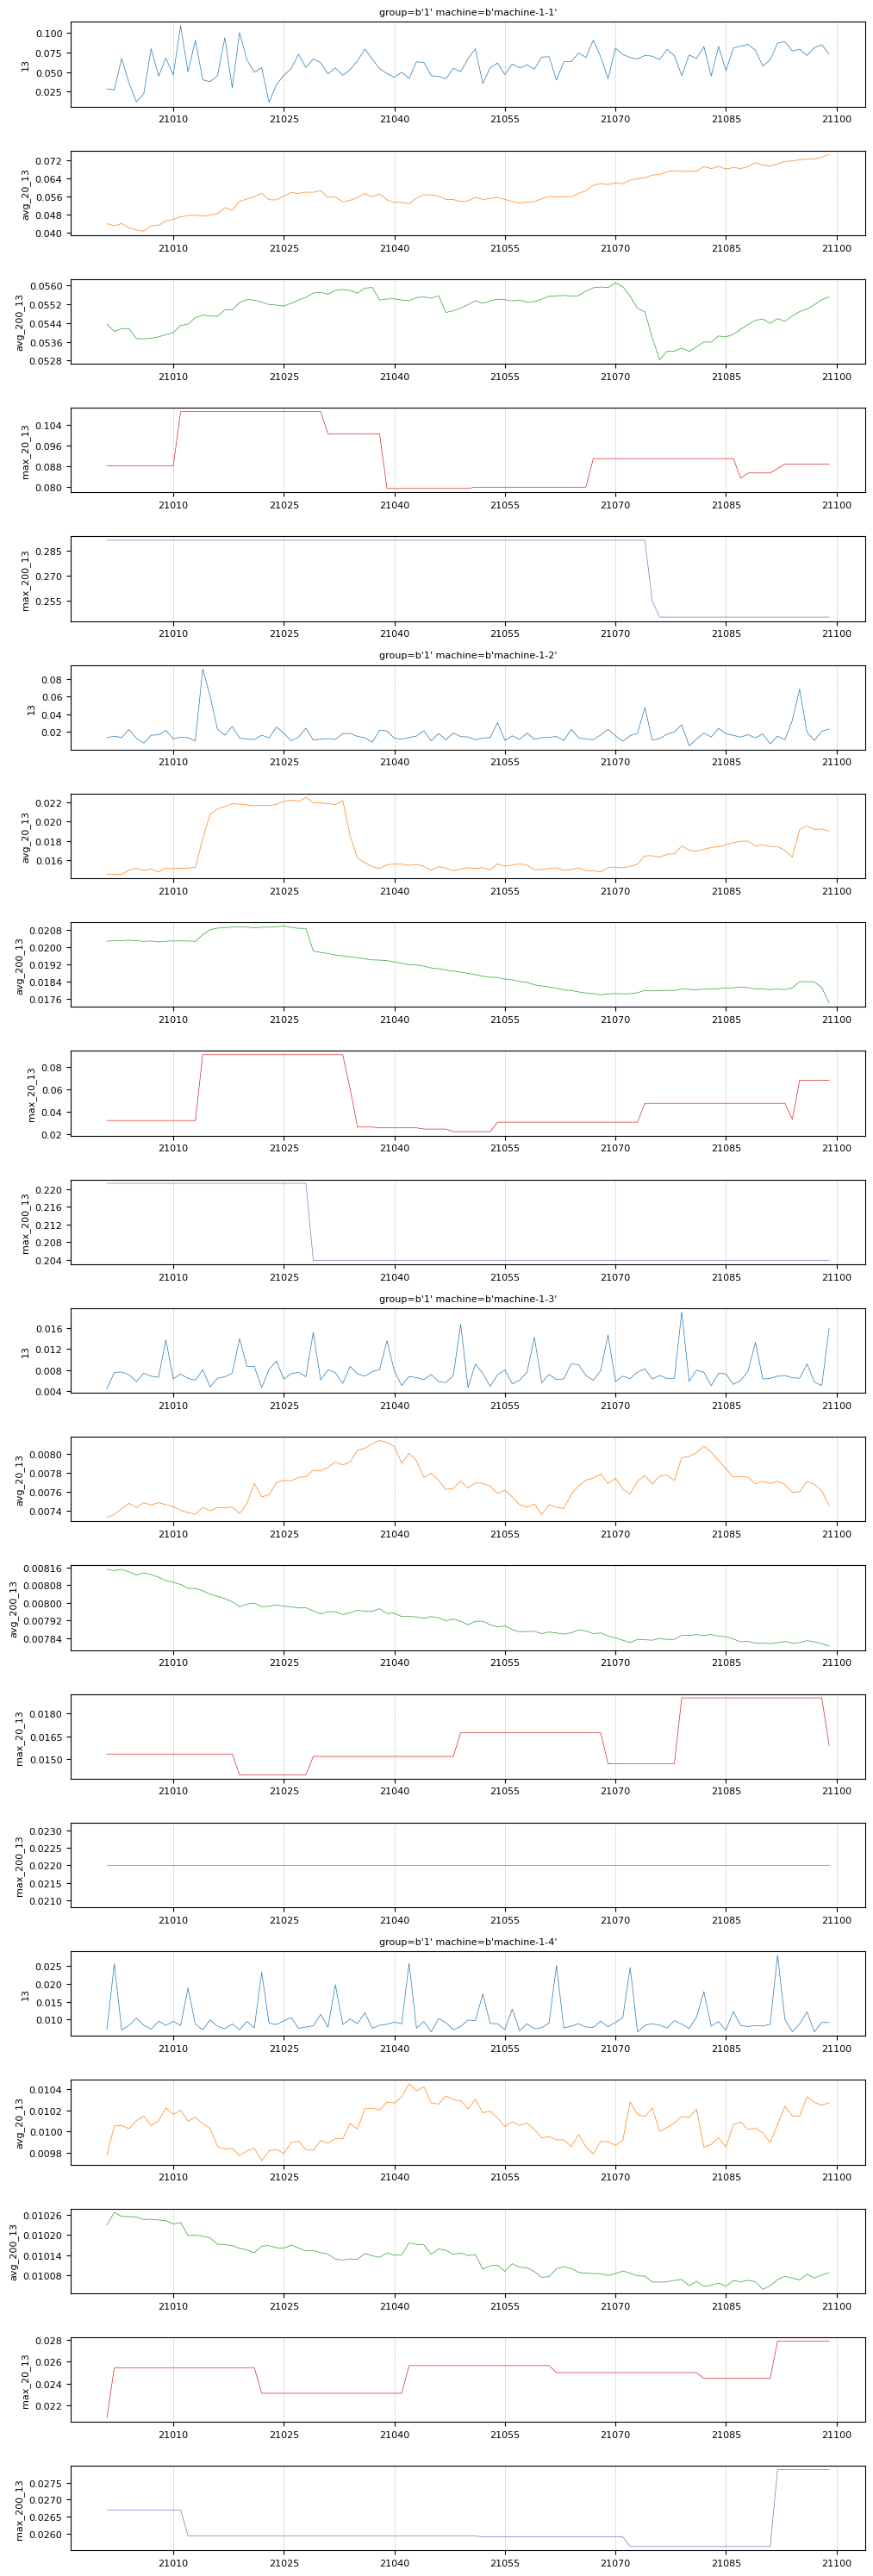

In [20]:
f13_stats = features[["13", "avg_20_13", "avg_200_13", "max_20_13", "max_200_13"]]
timestamps = f13_stats.timestamps()
f13_stats = f13_stats.filter((timestamps > 21000) & (timestamps < 21100))
f13_stats.plot()

Number of samples in train set 530740
Number of positive (anomalous) samples in train set 19924
Number of samples in test set 177680
Number of positive (anomalous) samples in test set 9520
Iteration 1, loss = 0.17260812
Iteration 2, loss = 0.09420537
Iteration 3, loss = 0.06783340
Iteration 4, loss = 0.05412164
Iteration 5, loss = 0.04603323
Iteration 6, loss = 0.04059648
Iteration 7, loss = 0.03653129
Iteration 8, loss = 0.03327009
Iteration 9, loss = 0.03076452
Iteration 10, loss = 0.02855370
Iteration 11, loss = 0.02682792
Iteration 12, loss = 0.02524408
Iteration 13, loss = 0.02399214
Iteration 14, loss = 0.02275639
Iteration 15, loss = 0.02170997
Iteration 16, loss = 0.02082780
Iteration 17, loss = 0.01998944
Iteration 18, loss = 0.01925486
Iteration 19, loss = 0.01839673
Training loss did not improve more than tol=0.001000 for 3 consecutive epochs. Stopping.
Train score: 0.9278915262716106
Test score: 0.7628107005233757
Train predictions
Test predictions


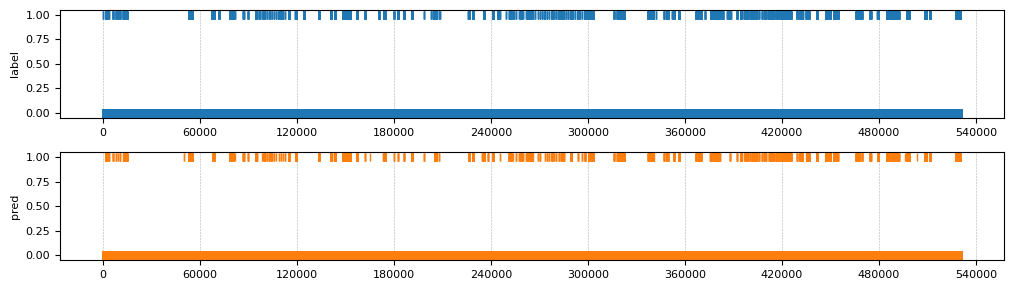

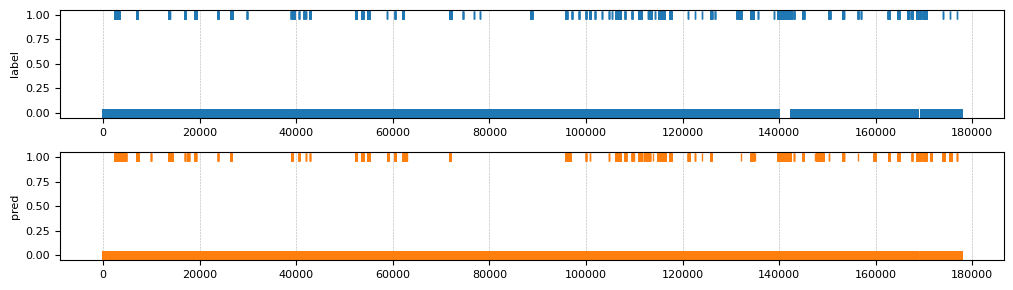

In [21]:
X_train, y_train, X_test, y_test = make_datasets(features, labels)
model = train(X_train, y_train)
eval(model, X_train, y_train, X_test, y_test)

That's quite an improvement! Our model seems to not be generalizing as well as before, but these new features have definitely helped it learn to recognize anomalies.

### Per-group features

As of now, each machine's events only have access to that same machine's lagged values and moving statistics.

In some cases, giving the model information about each entity's parent can be helpful. In this case, that could mean for example providing information to each machine's events about the average value of each metric in its group (remember that each machine belongs to one of 3 groups). In this case we don't know the semantics of what a group means and this could be of little to no use - but in other contexts it can be incredibly useful, such as feeding a store's aggregated sales to each product, or one country's music preferences to each user in it!

To compute these hierarchically-aggregated features, Temporian's indexes and `.propagate()` operator are incredibly powerful.

In [22]:
grouped_features = []

# Drop the "machine" index to obtain an EventSet indexed by group only
# Operators will now operate on each group, instead of on each machine!
grouped_raw_features = raw_features.drop_index("machine", keep=False)

grouped_features.append(grouped_raw_features.moving_sum(1).prefix("gr_sum_").propagate(raw_features, resample=True))
grouped_features.append(grouped_raw_features.simple_moving_average(10).prefix("gr_sma_10_").propagate(raw_features, resample=True))
grouped_features.append(grouped_raw_features.simple_moving_average(100).prefix("gr_sma_100_").propagate(raw_features, resample=True))
grouped_features.append(grouped_raw_features.simple_moving_average(1000).prefix("gr_sma_1000_").propagate(raw_features, resample=True))

features = tp.glue(raw_features, *lag_features, *moving_statistic_features, *grouped_features)
features

timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,lag_1_0,lag_1_1,lag_1_2,lag_1_3,lag_1_4,lag_1_5,lag_1_6,lag_1_7,lag_1_8,lag_1_9,lag_1_10,lag_1_11,lag_1_12,lag_1_13,lag_1_14,lag_1_15,lag_1_16,lag_1_17,lag_1_18,lag_1_19,lag_1_20,lag_1_21,lag_1_22,lag_1_23,lag_1_24,lag_1_25,lag_1_26,lag_1_27,lag_1_28,lag_1_29,lag_1_30,lag_1_31,lag_1_32,lag_1_33,lag_1_34,lag_1_35,lag_1_36,lag_1_37,lag_2_0,lag_2_1,lag_2_2,lag_2_3,lag_2_4,lag_2_5,lag_2_6,lag_2_7,lag_2_8,lag_2_9,lag_2_10,lag_2_11,lag_2_12,lag_2_13,lag_2_14,lag_2_15,lag_2_16,lag_2_17,lag_2_18,lag_2_19,lag_2_20,lag_2_21,lag_2_22,lag_2_23,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,…
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,…
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,0,0,0.1274,0.09449,0.09817,0.07752,0.9422,0.0184,0.03411,0.01696,0,0.08093,0,0.008596,0.07093,0.05147,0.000386,2.2e-05,0.0666,0.06667,0,0,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,3

Number of samples in train set 530740
Number of positive (anomalous) samples in train set 19924
Number of samples in test set 177680
Number of positive (anomalous) samples in test set 9520
Iteration 1, loss = 0.14685728
Iteration 2, loss = 0.08572098
Iteration 3, loss = 0.06695533
Iteration 4, loss = 0.05623494
Iteration 5, loss = 0.04881369
Iteration 6, loss = 0.04336522
Iteration 7, loss = 0.03922145
Iteration 8, loss = 0.03603040
Iteration 9, loss = 0.03323494
Iteration 10, loss = 0.03095507
Iteration 11, loss = 0.02898562
Iteration 12, loss = 0.02727444
Iteration 13, loss = 0.02590908
Iteration 14, loss = 0.02464837
Iteration 15, loss = 0.02340969
Iteration 16, loss = 0.02255808
Iteration 17, loss = 0.02157098
Iteration 18, loss = 0.02080084
Iteration 19, loss = 0.02000000
Training loss did not improve more than tol=0.001000 for 3 consecutive epochs. Stopping.
Train score: 0.9398245681833778
Test score: 0.7033168572420181
Train predictions
Test predictions


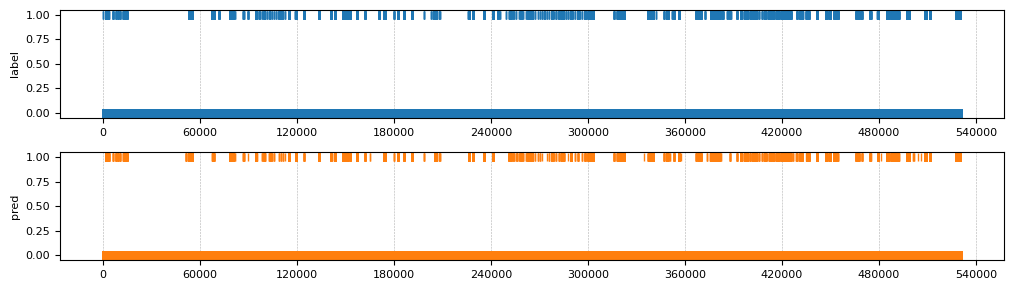

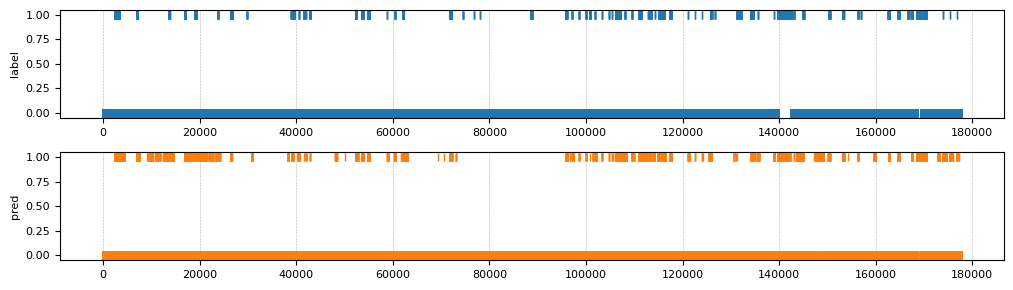

In [23]:
X_train, y_train, X_test, y_test = make_datasets(features, labels)
model = train(X_train, y_train)
eval(model, X_train, y_train, X_test, y_test)

Seems to have helped marginally :)

## Wrapping up

In this notebook we learned how to perform feature engineering and visualization using Temporian, applying it to a real-world anomaly detection use case.

There's some further work that could be done in this problem! Here's some ideas:
- Train a larger model! Our two-layer MLP has been alright, but a more capable model would definitely be able to find new patterns in the data - although it'll probably require some extra regularization work too
- Use the dataset's [unlabeled train data](https://github.com/NetManAIOps/OmniAnomaly/tree/master/ServerMachineDataset/train) to craft an unsupervised solution, and then test it on the labeled test data we used for this notebook.
- Keep adding new features! As we demonstrated, a very simple model can go a long way if the correct features are provided to it. This is where Temporian shines - check out the full list of operators in the [API Reference](https://temporian.readthedocs.io/en/stable/reference/#operators) for some inspiration!